# Main Notebook: NLP Series Workshop 3: Recurrent Seq2Seq for Language Translation

Conventions used:

❗ - Required <br>
❓ - Question <br>

Credit to these wonderful resources which we used as a basis for this workshop: 

* https://keras.io/examples/nlp/lstm_seq2seq/
* https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
* https://www.analyticsvidhya.com/blog/2020/08/a-simple-introduction-to-sequence-to-sequence-models/#:~:text=Sequence%20to%20Sequence%20

# 1. Setup and Exploration

## 1.1. Setup

The dataset we'll use can be found here: http://www.manythings.org/anki/fra-eng.zip

Download Dataset

In [1]:
!curl -O http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6457k  100 6457k    0     0  53.8M      0 --:--:-- --:--:-- --:--:-- 53.8M
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


Import Libraries

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd

Configuration

In [20]:
batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = "fra.txt"
data = pd.read_csv(data_path, header=None, sep="\t", names=["English","French", "Citation"], encoding="utf-8")

## 1.2. Exploration

This data set is split into short English sentences and their French translations. Let's take a look!

In [21]:
data

,English,French,Citation
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
194508,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
194509,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
194510,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...
194511,If someone who doesn't know your background sa...,Si quelqu'un qui ne connaît pas vos antécédent...,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [22]:
data = data.head(num_samples)

In [23]:
data

,English,French,Citation
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
4,Hi.,Salut.,CC-BY 2.0 (France) Attribution: tatoeba.org #5...
...,...,...,...
9995,Happy holidays.,Bonnes vacances !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9996,Has it arrived?,Est-ce que c'est arrivé ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
9997,Have they gone?,Sont-ils partis ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9998,Have they gone?,Sont-elles parties ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


# 2. Preprocessing

First, let's split up the data.

Our input text is English and our output text are the corresponding French translations. We'll save all this data to lists `input_texts` and `target_texts`.

From these arrays, we'll create 2 sets.
- `input_characters` will be all the unique characters in the input text 
- `target_characters` will be all the unique characters in the target text

A set is like an array, but there are *no duplicate elements*. These sets will be useful in our next steps of preprocessing!

In [31]:
# get all sentences from input (English) and target (French)
input_texts = data['English'].to_numpy()
target_texts = data['French'].to_numpy()

# get all unique characters in input and target using set()
input_characters = set(''.join(input_texts))
target_characters = set(''.join(target_texts))

In [32]:
input_texts

array(['Go.', 'Go.', 'Go.', ..., 'Have they gone?', 'Have they gone?',
       'Have you eaten?'], dtype=object)

In [33]:
target_texts

array(['Va !', 'Marche.', 'Bouge !', ..., 'Sont-ils partis ?',
       'Sont-elles parties ?', 'Tu as mangé\u202f?'], dtype=object)

__TODO: INSERT VISUAL SHOWING WHAT `input_characters` AND `target_characters` ARE.__

## Encoding and Decoding

We have three important terms to know for this next section.

**Encoder:** The encoder processes each token in the input-sequence. It tries to cram all the information about the input-sequence into a vector of fixed length i.e. the ‘context vector’. After going through all the tokens, the encoder passes this vector onto the decoder.

**Context Vector:** A vector of numbers that encodes information in the input sequence (the English text). The Decoder's job is to turn this information into a French sentence.

**Decoder:** The decoder reads the context vector and tries to predict the target-sequence token by token.

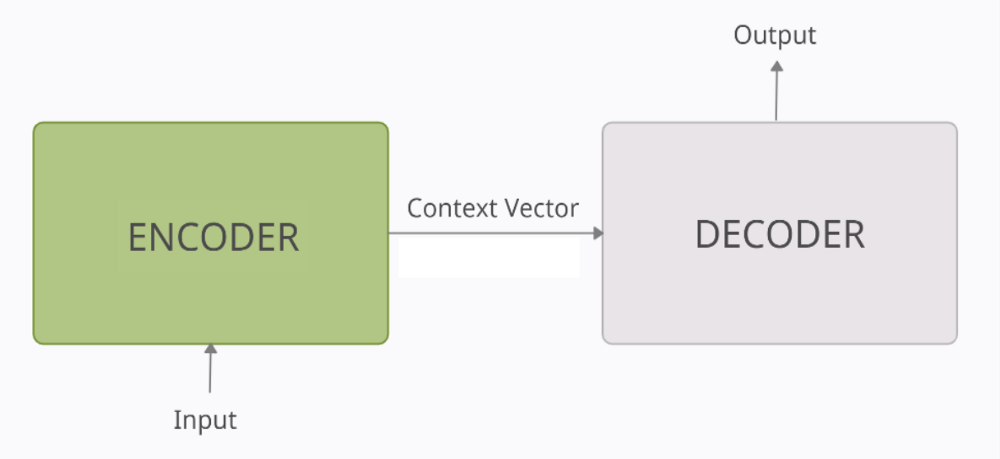

It's time to create some variables related to our tokens.

In our Seq2Seq model, the individual characters of the English and French words are referred to as tokens.

In [40]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

Let's check out some stats about our data!

In [41]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 91
Max sequence length for inputs: 15
Max sequence length for outputs: 57


### Preparing for Encoding & Decoding

We will be mapping from a given character to the index that represents said character in the encoder/decoder data

In [42]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

__TODO: INSERT A VISUAL SHOWING WHAT THESE 2 VARIABLES ARE.__

Now, we will create three arrays filled with zeros. These will be arrays based on the length of the input texts, the length of the longest sequence, and number of tokens.



In [45]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

In [47]:
print("encoder_input_data shape", encoder_input_data.shape)
print("decoder_input_data shape", decoder_input_data.shape)
print("decoder_target_data shape", decoder_target_data.shape)

encoder_input_data shape (10000, 15, 71)
decoder_input_data shape (10000, 57, 91)
decoder_target_data shape (10000, 57, 91)


#### In this section, we will be wrapping up preprocessing and finally building our encoder and decoder.

After the encoder reads the whole input-sequence, it passes the internal states (the context vector) to the decoder and this is where the prediction of output-sequence begins.

In [48]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0

    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

__TODO: INSERT A VISUAL HERE SHOWING WHAT THE LOOPS ABOVE ARE DOING.__

We have now vectorized our data and are ready to move on to the next step, building our model!

# 3. Building the Model

## What is a Seq2Seq model?

A Seq2Seq model is a type of Recurrent Neural Network (RNN) that we can use for language translation.

It commonly uses the Encoder-Decoder architecture, which we are using in this notebook.

### What is the Encoder-Decoder architecture (at a high level)?

The Encoder reads the input sequence and summarizes the information in something called the internal state vectors or context vector. We discard the outputs of the encoder and only preserve the internal states.

Using the final states of the encoder as its initial states, the decoder starts generating the output sequence, and these outputs are also taken into consideration for future outputs.

#### First, let's define an input sequence and process it.

We will be using LSTM layers, which provide a sequence of outputs rather than a single value output.

__TODO: INSERT A VISUAL HERE SHOWING THE LSTM ARCHITECTURE AND A BRIEF HIGH-LEVEL OVERVIEW OF WHAT IT IS.__

In [64]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

__TODO: INSERT VISUAL OF ENCODER ARCHITECTURE.__

We need to put these encoder inputs in the context vector and set up the decoder

In [65]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

Let's finish setting up the decoder:

In [66]:
# Set up the decoder to return full output sentences
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)

# We return to our internal states
# We add an LSTM layer for encoding and decoding
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
# Our decoder output layer
decoder_outputs = decoder_dense(decoder_outputs)

__TODO: INSERT VISUAL OF DECODER ARCHITECTURE.__

Finally, we can build our model!

In [67]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

__TODO: INSERT A DIAGRAM OF THE MODEL WE JUST BUILT.__

# 4. Training the Model

We'll use `fit()` to train our model.

- **encoder_input_data**: English training sentences
- **decoder_input_data**: encoded English sentences
- **decoder_target_data**: French sentences
- **epochs**: number of times the model will go through the dataset
- **batch_size**: number of training samples that go through the model

__TODO: INSERT VISUAL OF HOW THE MODEL IS TRAINING.__

In [ ]:
# Compile the model

model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

# Fit the model on the data & finetune it with validation data
model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("s2s")